In [1]:
import pandas as pd
import sys
import glob
import numpy as np
import datetime

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as PC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

In [2]:
csv_filepath = "/pscratch/sd/o/ocankur/data/resource_usage_paper"

In [3]:
def get_duration(dataframe, seconds=10):
    # remove jobs that take less than 10 secs.
    dataframe["start_time"] = pd.to_datetime(dataframe["start"], unit='s', utc=True)
    dataframe["end_time"] = pd.to_datetime(dataframe["end"], unit='s', utc=True)
    dataframe["duration"] = dataframe["end_time"] - dataframe["start_time"]
    dataframe = dataframe[dataframe["duration"] > datetime.timedelta(0,seconds)]
    return dataframe

In [4]:
def preprocess_data(ldms_dataframe, sacct_dataframe, metric, percentage=True):
    """
    Remove jobs that take less than 10 seconds.
    Filter out completed jobs.
    Filter out 'nstaff' and 'nstaff_g'
    """
    
    print("Number of LDMS data points before preprocessing: ", len(ldms_dataframe.index))
    
    if percentage:
        if metric == "mem_copy_utilization" or metric == "gpu_utilization":
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 100].copy()
        else:
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 1].copy()
            ldms_dataframe.loc[:, metric] = ldms_dataframe[metric] * 100
    
    sacct_dataframe = get_duration(sacct_dataframe, 10)
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff_g"]
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff"]
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["state"] == "COMPLETED"]
    
    sacct_dataframe.rename(columns={'jobidraw': 'jobid'}, inplace=True)
    merged_ldms = ldms_dataframe.merge(sacct_dataframe, on=["ProducerName", "jobid", "step"])
    
    print("Number of LDMS data points after preprocessing: ", len(merged_ldms.index))
    
    return merged_ldms

### FP16

In [5]:
df_fp16 = pd.read_parquet(csv_filepath + "/" + "dcgm.fp16_active.1692169200.1692428399.8.16_ldms.pq")
df_sacct_fp16 = pd.read_parquet(csv_filepath + "/" + "dcgm.fp16_active.1692169200.1692428399.8.16_saact.pq")
merged_ldms_fp16 = preprocess_data(df_fp16, df_sacct_fp16, metric="fp16_active", percentage=True)

Number of LDMS data points before preprocessing:  116804508
Number of LDMS data points after preprocessing:  52269268


In [6]:
merged_ldms_fp16 = merged_ldms_fp16[merged_ldms_fp16["Account"].str.contains("_g")]

#### Number of jobs that use FP16

In [7]:
jobs_without_zero_fp16 = merged_ldms_fp16.groupby('jobid').filter(lambda x: x['fp16_active'].sum() != 0)
num_fp16_jobs = jobs_without_zero_fp16['jobid'].nunique()
print(f"Number of jobs that use FP16: {num_fp16_jobs}")
print("Total number of jobs: ", merged_ldms_fp16[["jobid"]].nunique())

Number of jobs that use FP16: 82
Total number of jobs:  jobid    14594
dtype: int64


#### Node hours of jobs that use FP16

In [18]:
unique_jobs_without_zero_fp16 = jobs_without_zero_fp16.drop_duplicates(subset='jobid').copy()
unique_jobs_without_zero_fp16['duration_hours'] = unique_jobs_without_zero_fp16['duration'].dt.total_seconds() / 3600.0
unique_jobs_without_zero_fp16['node_hours'] = unique_jobs_without_zero_fp16['nnodes'] * unique_jobs_without_zero_fp16['duration_hours']

total_node_hours_fp16 = unique_jobs_without_zero_fp16['node_hours'].sum()
print(f"Total node hours of jobs that use FP16: {total_node_hours_fp16}")

Total node hours of jobs that use FP16: 280.4605555555555


#### CDF and PDF

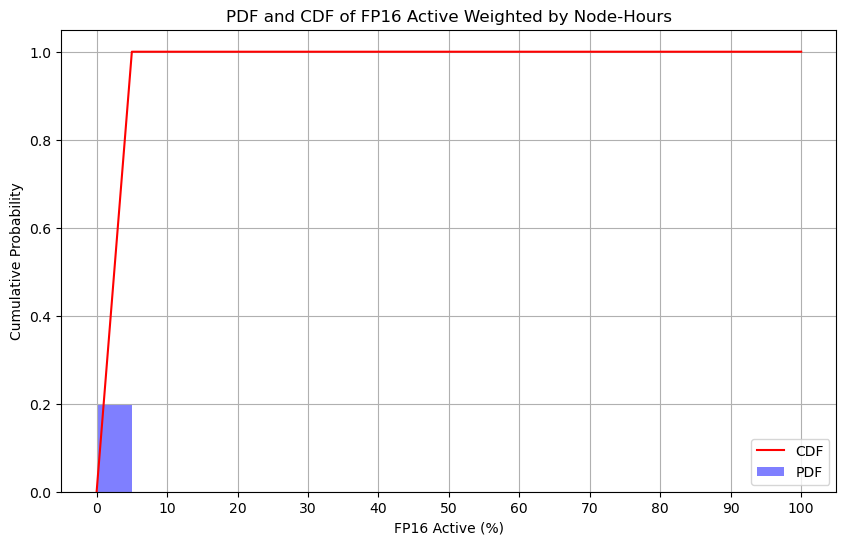

In [7]:
merged_ldms_fp16['duration_hours'] = merged_ldms_fp16['duration'].dt.total_seconds() / 3600

aggregated_data = merged_ldms_fp16.groupby('jobid').agg({
    'nnodes': 'first',  
    'duration_hours': 'first',  
    'fp16_active': 'mean'  # Does that makes sense????
})

# Calculate node-hours by multiplying duration by nnodes
aggregated_data['node_hours'] = aggregated_data['duration_hours'] * aggregated_data['nnodes']

weighted_fp16 = pd.DataFrame({
    'fp16_active': aggregated_data['fp16_active'],
    'weight': aggregated_data['node_hours']
})

bins = np.linspace(0, 100, 21) 

# Calculate histogram data for PDF
pdf_values, pdf_base = np.histogram(weighted_fp16['fp16_active'], bins=bins, weights=weighted_fp16['weight'], density=True)
pdf_widths = np.diff(pdf_base)
pdf_centers = pdf_base[:-1] + pdf_widths / 2

cdf_values, _ = np.histogram(weighted_fp16['fp16_active'], bins=bins, weights=weighted_fp16['weight'])
cdf_values = np.cumsum(cdf_values)  
cdf_values = np.insert(cdf_values, 0, 0)  
cdf_values = cdf_values / cdf_values[-1]

plt.figure(figsize=(10, 6))
plt.bar(pdf_centers, pdf_values, width=pdf_widths, color='blue', alpha=0.5, label='PDF')
plt.plot(pdf_base, cdf_values, color='red', label='CDF') 
plt.xlabel('FP16 Active (%)')
plt.ylabel('Cumulative Probability')
plt.title('PDF and CDF of FP16 Active Weighted by Node-Hours')
plt.xticks(np.arange(0, 101, 10))
plt.grid(True)
plt.legend()

plt.show()

#### Summary of statistics (Find better ways to do this)

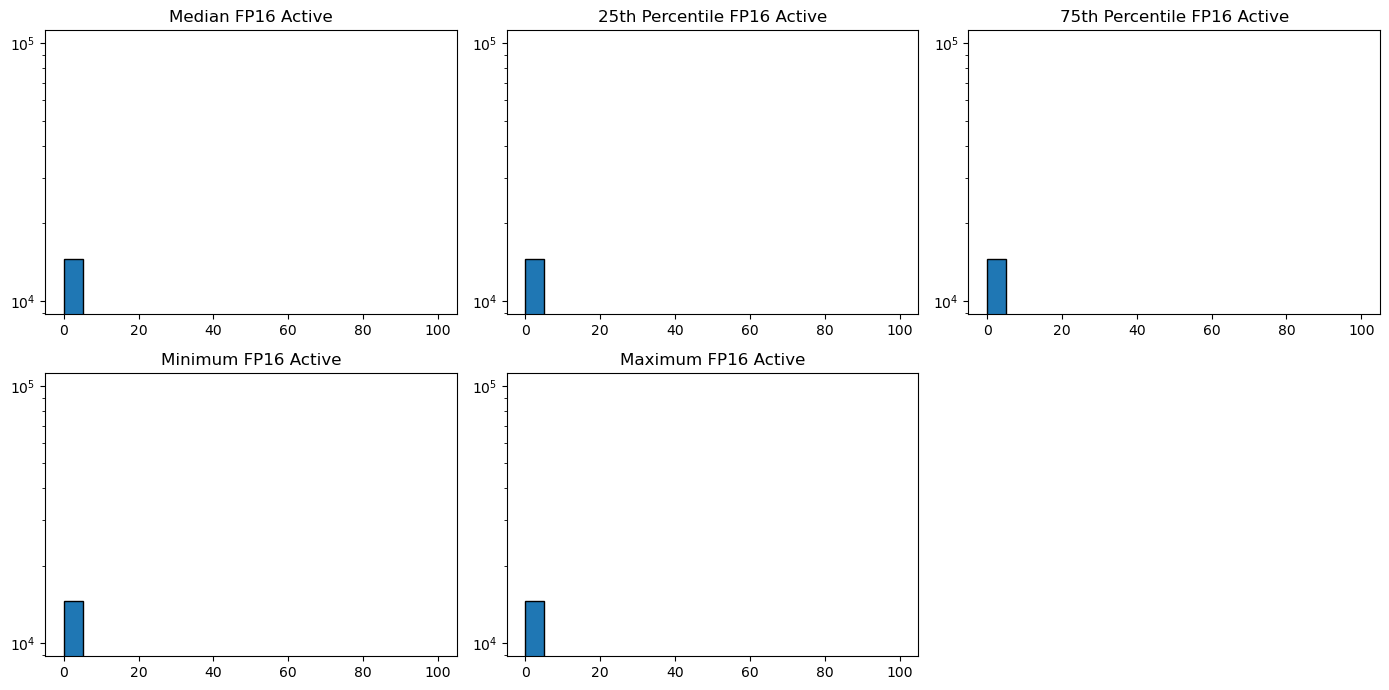

In [8]:
summary_stats = merged_ldms_fp16.groupby('jobid')['fp16_active'].describe(percentiles=[.25, .5, .75]).reset_index()

bins = range(0, 101, 5)  # 0-5, 5-10, ..., 95-100

plt.figure(figsize=(14, 7))

plt.subplot(2, 3, 1)
plt.hist(summary_stats['50%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Median FP16 Active')

plt.subplot(2, 3, 2)
plt.hist(summary_stats['25%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('25th Percentile FP16 Active')

plt.subplot(2, 3, 3)
plt.hist(summary_stats['75%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('75th Percentile FP16 Active')

plt.subplot(2, 3, 4)
plt.hist(summary_stats['min'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Minimum FP16 Active')

plt.subplot(2, 3, 5)
plt.hist(summary_stats['max'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Maximum FP16 Active')

plt.tight_layout()
plt.show()

### FP32

In [52]:
df_fp32 = pd.read_parquet(csv_filepath + "/" + "dcgm.fp32_active.1692169200.1692428399.8.16_ldms.pq")
df_sacct_fp32 = pd.read_parquet(csv_filepath + "/" + "dcgm.fp32_active.1692169200.1692428399.8.16_saact.pq")
merged_ldms_fp32 = preprocess_data(df_fp32, df_sacct_fp32, metric="fp32_active", percentage=True)

Number of LDMS data points before preprocessing:  116805858
Number of LDMS data points after preprocessing:  52268732


In [53]:
merged_ldms_fp32 = merged_ldms_fp32[merged_ldms_fp32["Account"].str.contains("_g")]

#### Number of jobs that use FP32

In [11]:
jobs_without_zero_fp32 = merged_ldms_fp32.groupby('jobid').filter(lambda x: x['fp32_active'].sum() != 0)
num_fp32_jobs = jobs_without_zero_fp32['jobid'].nunique()
print(f"Number of jobs that use FP32: {num_fp32_jobs}")
print("Total number of jobs: ", merged_ldms_fp32[["jobid"]].nunique())

Number of jobs that use FP32: 9678
Total number of jobs:  jobid    14595
dtype: int64


#### Node hours of jobs that use FP32

In [20]:
unique_jobs_without_zero_fp32 = jobs_without_zero_fp32.drop_duplicates(subset='jobid').copy()
unique_jobs_without_zero_fp32['duration_hours'] = unique_jobs_without_zero_fp32['duration'].dt.total_seconds() / 3600.0
unique_jobs_without_zero_fp32['node_hours'] = unique_jobs_without_zero_fp32['nnodes'] * unique_jobs_without_zero_fp32['duration_hours']

total_node_hours_fp32 = unique_jobs_without_zero_fp32['node_hours'].sum()
print(f"Total node hours of jobs that use FP32: {total_node_hours_fp32}")

Total node hours of jobs that use FP32: 38187.98611111111


#### CDF and PDF

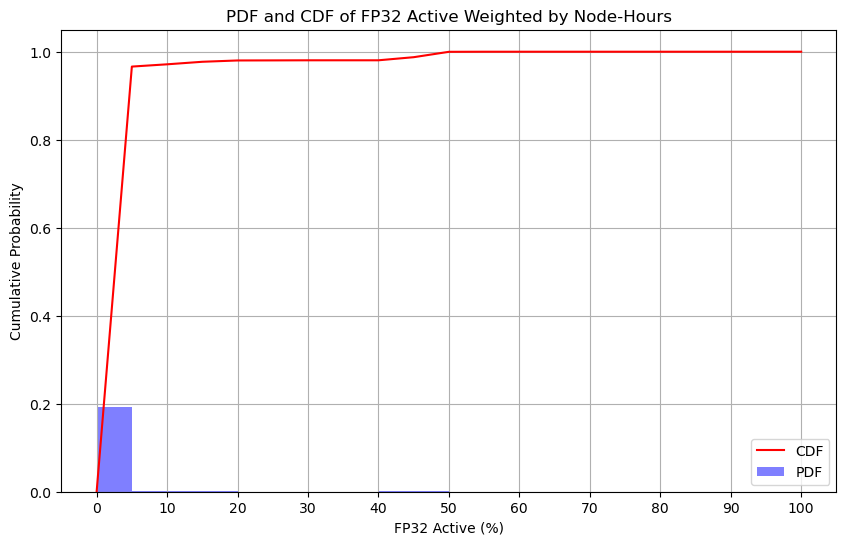

In [54]:
merged_ldms_fp32['duration_hours'] = merged_ldms_fp32['duration'].dt.total_seconds() / 3600

aggregated_data = merged_ldms_fp32.groupby('jobid').agg({
    'nnodes': 'first',  
    'duration_hours': 'first',  
    'fp32_active': 'mean'  # Does that makes sense????
})

# Calculate node-hours by multiplying duration by nnodes
aggregated_data['node_hours'] = aggregated_data['duration_hours'] * aggregated_data['nnodes']

weighted_fp32 = pd.DataFrame({
    'fp32_active': aggregated_data['fp32_active'],
    'weight': aggregated_data['node_hours']
})

bins = np.linspace(0, 100, 21) 

# Calculate histogram data for PDF
pdf_values, pdf_base = np.histogram(weighted_fp32['fp32_active'], bins=bins, weights=weighted_fp32['weight'], density=True)
pdf_widths = np.diff(pdf_base)
pdf_centers = pdf_base[:-1] + pdf_widths / 2

cdf_values, _ = np.histogram(weighted_fp32['fp32_active'], bins=bins, weights=weighted_fp32['weight'])
cdf_values = np.cumsum(cdf_values)  
cdf_values = np.insert(cdf_values, 0, 0)  
cdf_values = cdf_values / cdf_values[-1]

plt.figure(figsize=(10, 6))
plt.bar(pdf_centers, pdf_values, width=pdf_widths, color='blue', alpha=0.5, label='PDF')
plt.plot(pdf_base, cdf_values, color='red', label='CDF') 
plt.xlabel('FP32 Active (%)')
plt.ylabel('Cumulative Probability')
plt.title('PDF and CDF of FP32 Active Weighted by Node-Hours')
plt.xticks(np.arange(0, 101, 10))
plt.grid(True)
plt.legend()

plt.show()

#### Summary of statistics (Find better ways to do this)

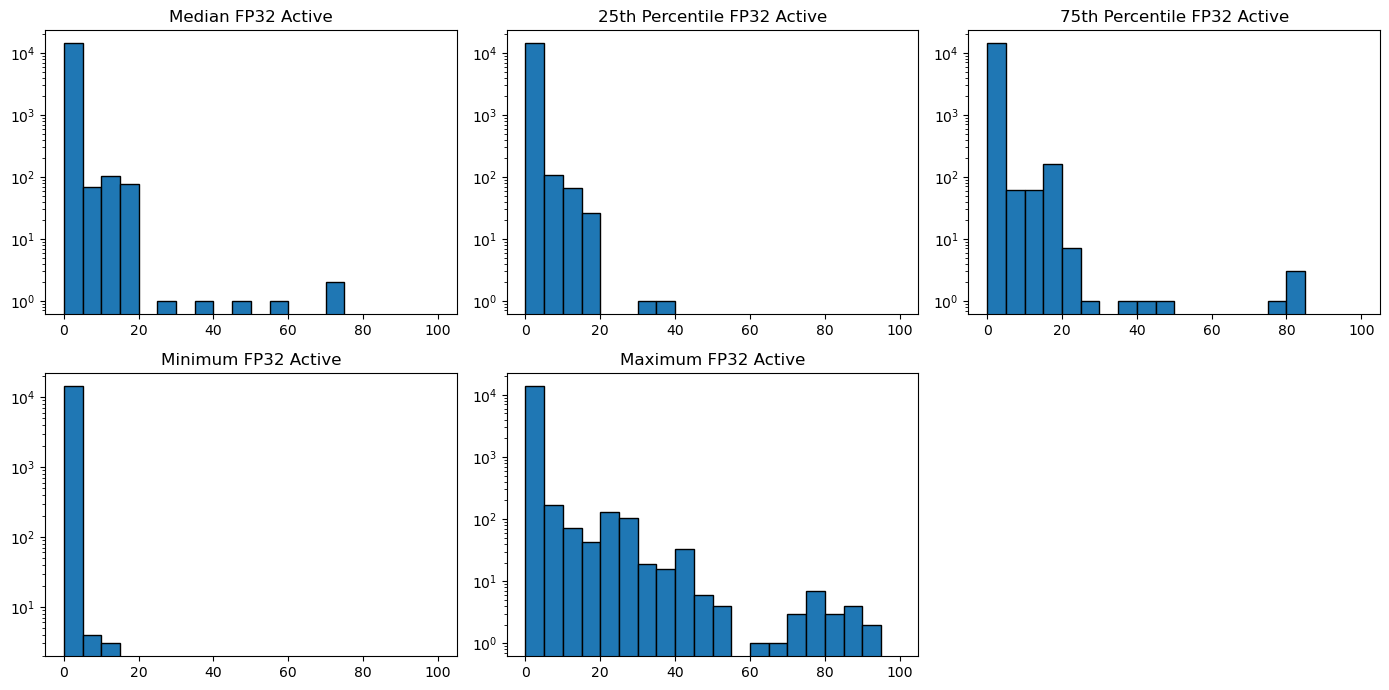

In [55]:
summary_stats = merged_ldms_fp32.groupby('jobid')['fp32_active'].describe(percentiles=[.25, .5, .75]).reset_index()

bins = range(0, 101, 5)  # 0-5, 5-10, ..., 95-100

plt.figure(figsize=(14, 7))

plt.subplot(2, 3, 1)
plt.hist(summary_stats['50%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Median FP32 Active')

plt.subplot(2, 3, 2)
plt.hist(summary_stats['25%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('25th Percentile FP32 Active')

plt.subplot(2, 3, 3)
plt.hist(summary_stats['75%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('75th Percentile FP32 Active')

plt.subplot(2, 3, 4)
plt.hist(summary_stats['min'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Minimum FP32 Active')

plt.subplot(2, 3, 5)
plt.hist(summary_stats['max'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Maximum FP32 Active')

plt.tight_layout()
plt.show()

### FP64

In [15]:
df_fp64 = pd.read_parquet(csv_filepath + "/" + "dcgm.fp64_active.1692169200.1692428399.8.16_ldms.pq")
df_sacct_fp64 = pd.read_parquet(csv_filepath + "/" + "dcgm.fp64_active.1692169200.1692428399.8.16_saact.pq")
merged_ldms_fp64 = preprocess_data(df_fp64, df_sacct_fp64, metric="fp64_active", percentage=True)

Number of LDMS data points before preprocessing:  116806763
Number of LDMS data points after preprocessing:  52269730


In [10]:
merged_ldms_fp64 = merged_ldms_fp64[merged_ldms_fp64["Account"].str.contains("_g")]

#### Number of jobs that use FP64

In [7]:
jobs_without_zero_fp64 = merged_ldms_fp64.groupby('jobid').filter(lambda x: x['fp64_active'].sum() != 0)
num_fp64_jobs = jobs_without_zero_fp64['jobid'].nunique()
print(f"Number of jobs that use FP64: {num_fp64_jobs}")
print("Total number of jobs: ", merged_ldms_fp64[["jobid"]].nunique())

Number of jobs that use FP64: 10259
Total number of jobs:  jobid    14597
dtype: int64


#### Node hours of jobs that use FP64

In [8]:
unique_jobs_without_zero_fp64 = jobs_without_zero_fp64.drop_duplicates(subset='jobid').copy()
unique_jobs_without_zero_fp64['duration_hours'] = unique_jobs_without_zero_fp64['duration'].dt.total_seconds() / 3600.0
unique_jobs_without_zero_fp64['node_hours'] = unique_jobs_without_zero_fp64['nnodes'] * unique_jobs_without_zero_fp64['duration_hours']

total_node_hours_fp64 = unique_jobs_without_zero_fp64['node_hours'].sum()
print(f"Total node hours of jobs that use FP64: {total_node_hours_fp64}")

Total node hours of jobs that use FP64: 38413.056666666664


#### CDF and PDF

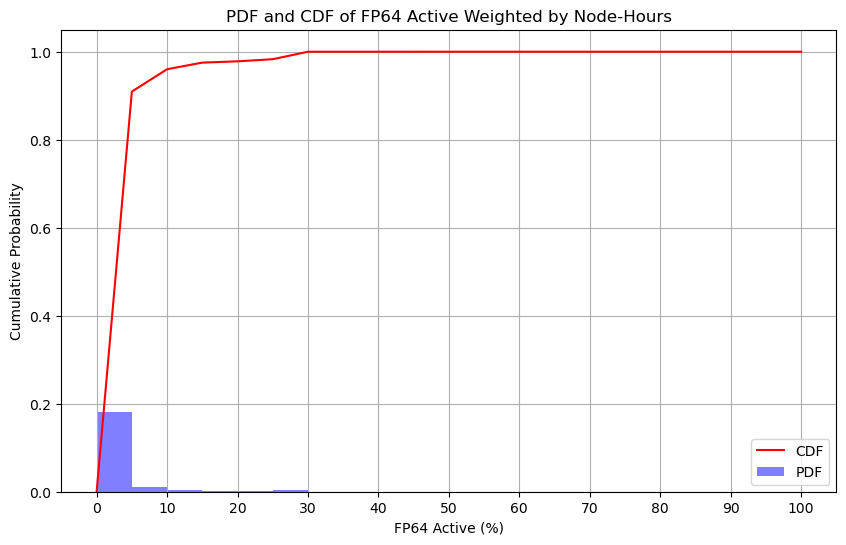

In [16]:
merged_ldms_fp64['duration_hours'] = merged_ldms_fp64['duration'].dt.total_seconds() / 3600

aggregated_data = merged_ldms_fp64.groupby('jobid').agg({
    'nnodes': 'first',  
    'duration_hours': 'first',  
    'fp64_active': 'mean'  # Does that makes sense????
})

# Calculate node-hours by multiplying duration by nnodes
aggregated_data['node_hours'] = aggregated_data['duration_hours'] * aggregated_data['nnodes']

weighted_fp64 = pd.DataFrame({
    'fp64_active': aggregated_data['fp64_active'],
    'weight': aggregated_data['node_hours']
})

bins = np.linspace(0, 100, 21) 

# Calculate histogram data for PDF
pdf_values, pdf_base = np.histogram(weighted_fp64['fp64_active'], bins=bins, weights=weighted_fp64['weight'], density=True)
pdf_widths = np.diff(pdf_base)
pdf_centers = pdf_base[:-1] + pdf_widths / 2

cdf_values, _ = np.histogram(weighted_fp64['fp64_active'], bins=bins, weights=weighted_fp64['weight'])
cdf_values = np.cumsum(cdf_values)  
cdf_values = np.insert(cdf_values, 0, 0)  
cdf_values = cdf_values / cdf_values[-1]

plt.figure(figsize=(10, 6))
plt.bar(pdf_centers, pdf_values, width=pdf_widths, color='blue', alpha=0.5, label='PDF')
plt.plot(pdf_base, cdf_values, color='red', label='CDF') 
plt.xlabel('FP64 Active (%)')
plt.ylabel('Cumulative Probability')
plt.title('PDF and CDF of FP64 Active Weighted by Node-Hours')
plt.xticks(np.arange(0, 101, 10))
plt.grid(True)
plt.legend()

plt.show()

#### Summary of statistics (Find better ways to do this)

In [17]:
# Group by 'jobid' and calculate summary statistics
summary_stats = merged_ldms_fp64.groupby('jobid')['fp64_active'].describe(percentiles=[.25, .5, .75]).reset_index()

In [39]:
summary_stats

,jobid,count,mean,std,min,25%,50%,75%,max
0,3366460,150.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.0000
1,3368245,1.0,0.000000,NaN,0.0,0.0,0.00000,0.00000,0.0000
2,5360505,8466.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.0000
3,5811681,1.0,0.000000,NaN,0.0,0.0,0.00000,0.00000,0.0000
4,6917159,103361.0,0.000007,0.000334,0.0,0.0,0.00000,0.00000,0.0195
...,...,...,...,...,...,...,...,...,...
15525,14068349,116.0,1.217886,0.813747,0.0,0.0,1.77100,1.78915,1.8293
15526,14068350,1004.0,0.000000,0.000000,0.0,0.0,0.00000,0.00000,0.0000
15527,14068352,112.0,0.985381,0.859987,0.0,0.0,1.71805,1.74950,1.7960
15528,14068358,108.0,0.991441,0.746914,0.0,0.0,1.54850,1.56935,1.6075


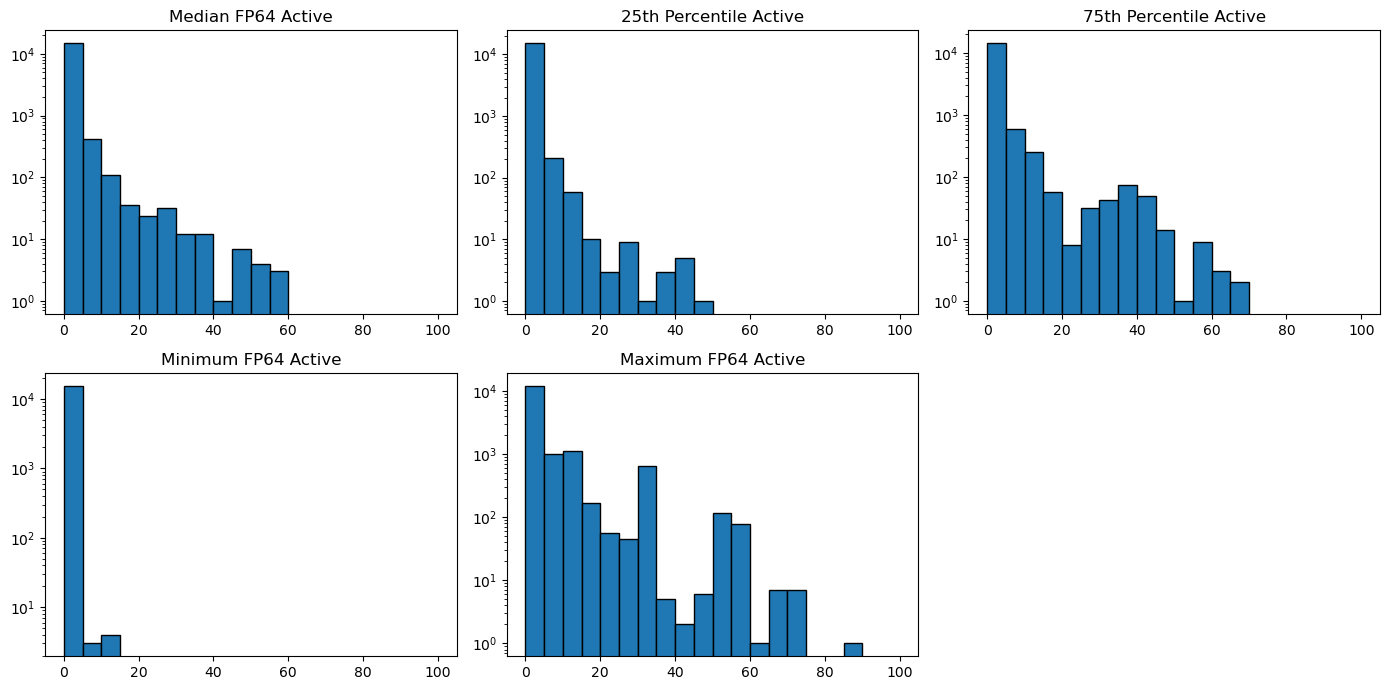

In [51]:
bins = range(0, 101, 5)  # 0-5, 5-10, ..., 95-100

plt.figure(figsize=(14, 7))

plt.subplot(2, 3, 1)
plt.hist(summary_stats['50%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Median FP64 Active')

plt.subplot(2, 3, 2)
plt.hist(summary_stats['25%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('25th Percentile Active')

plt.subplot(2, 3, 3)
plt.hist(summary_stats['75%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('75th Percentile Active')

plt.subplot(2, 3, 4)
plt.hist(summary_stats['min'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Minimum FP64 Active')

plt.subplot(2, 3, 5)
plt.hist(summary_stats['max'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Maximum FP64 Active')

plt.tight_layout()
plt.show()

### Tensor

In [10]:
df_tensor = pd.read_parquet(csv_filepath + "/" + "dcgm.tensor_active.1692169200.1692428399.8.16_ldms.pq")
df_sacct_tensor = pd.read_parquet(csv_filepath + "/" + "dcgm.tensor_active.1692169200.1692428399.8.16_saact.pq")
merged_ldms_tensor = preprocess_data(df_tensor, df_sacct_tensor, metric="tensor_active", percentage=True)

Number of LDMS data points before preprocessing:  116807383
Number of LDMS data points after preprocessing:  52269956


In [11]:
merged_ldms_tensor = merged_ldms_tensor[merged_ldms_tensor["Account"].str.contains("_g")]

#### Number of jobs that use FP64

In [32]:
jobs_without_zero_tensor = merged_ldms_tensor.groupby('jobid').filter(lambda x: x['tensor_active'].sum() != 0)
num_tensor_jobs = jobs_without_zero_tensor['jobid'].nunique()
print(f"Number of jobs that use Tensor: {num_tensor_jobs}")
print("Total number of jobs: ", merged_ldms_tensor[["jobid"]].nunique())

Number of jobs that use Tensor: 10845
Total number of jobs:  jobid    14595
dtype: int64


#### Node hours of jobs that use Tensor

In [34]:
unique_jobs_without_zero_tensor = jobs_without_zero_tensor.drop_duplicates(subset='jobid').copy()
unique_jobs_without_zero_tensor['duration_hours'] = unique_jobs_without_zero_tensor['duration'].dt.total_seconds() / 3600.0
unique_jobs_without_zero_tensor['node_hours'] = unique_jobs_without_zero_tensor['nnodes'] * unique_jobs_without_zero_tensor['duration_hours']

total_node_hours_tensor = unique_jobs_without_zero_tensor['node_hours'].sum()
print(f"Total node hours of jobs that use Tensor: {total_node_hours_tensor}")

Total node hours of jobs that use Tensor: 39736.15611111111


#### CDF and PDF

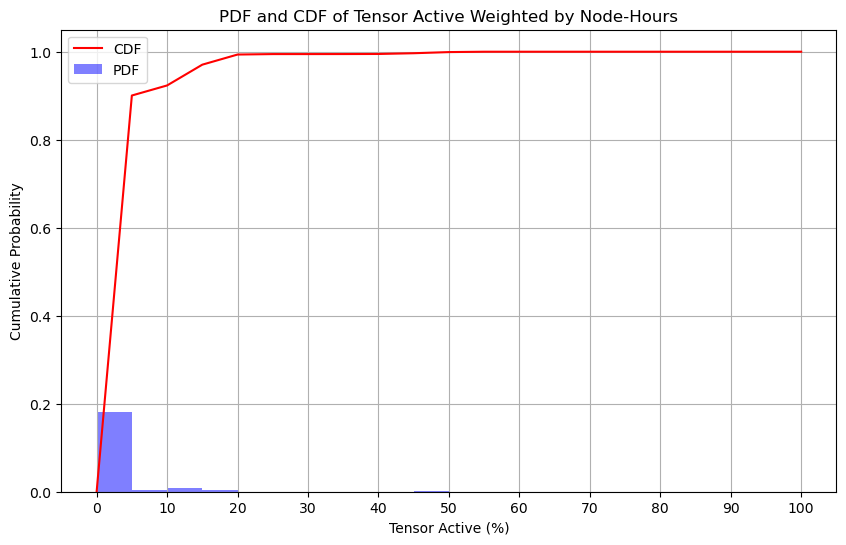

In [12]:
merged_ldms_tensor['duration_hours'] = merged_ldms_tensor['duration'].dt.total_seconds() / 3600

aggregated_data = merged_ldms_tensor.groupby('jobid').agg({
    'nnodes': 'first',  
    'duration_hours': 'first',  
    'tensor_active': 'mean'  # Does that makes sense????
})

# Calculate node-hours by multiplying duration by nnodes
aggregated_data['node_hours'] = aggregated_data['duration_hours'] * aggregated_data['nnodes']

weighted_tensor = pd.DataFrame({
    'tensor_active': aggregated_data['tensor_active'],
    'weight': aggregated_data['node_hours']
})

bins = np.linspace(0, 100, 21) 

# Calculate histogram data for PDF
pdf_values, pdf_base = np.histogram(weighted_tensor['tensor_active'], bins=bins, weights=weighted_tensor['weight'], density=True)
pdf_widths = np.diff(pdf_base)
pdf_centers = pdf_base[:-1] + pdf_widths / 2

cdf_values, _ = np.histogram(weighted_tensor['tensor_active'], bins=bins, weights=weighted_tensor['weight'])
cdf_values = np.cumsum(cdf_values)  
cdf_values = np.insert(cdf_values, 0, 0)  
cdf_values = cdf_values / cdf_values[-1]

plt.figure(figsize=(10, 6))
plt.bar(pdf_centers, pdf_values, width=pdf_widths, color='blue', alpha=0.5, label='PDF')
plt.plot(pdf_base, cdf_values, color='red', label='CDF') 
plt.xlabel('Tensor Active (%)')
plt.ylabel('Cumulative Probability')
plt.title('PDF and CDF of Tensor Active Weighted by Node-Hours')
plt.xticks(np.arange(0, 101, 10))
plt.grid(True)
plt.legend()

plt.show()

#### Summary of statistics (Find better ways to do this)

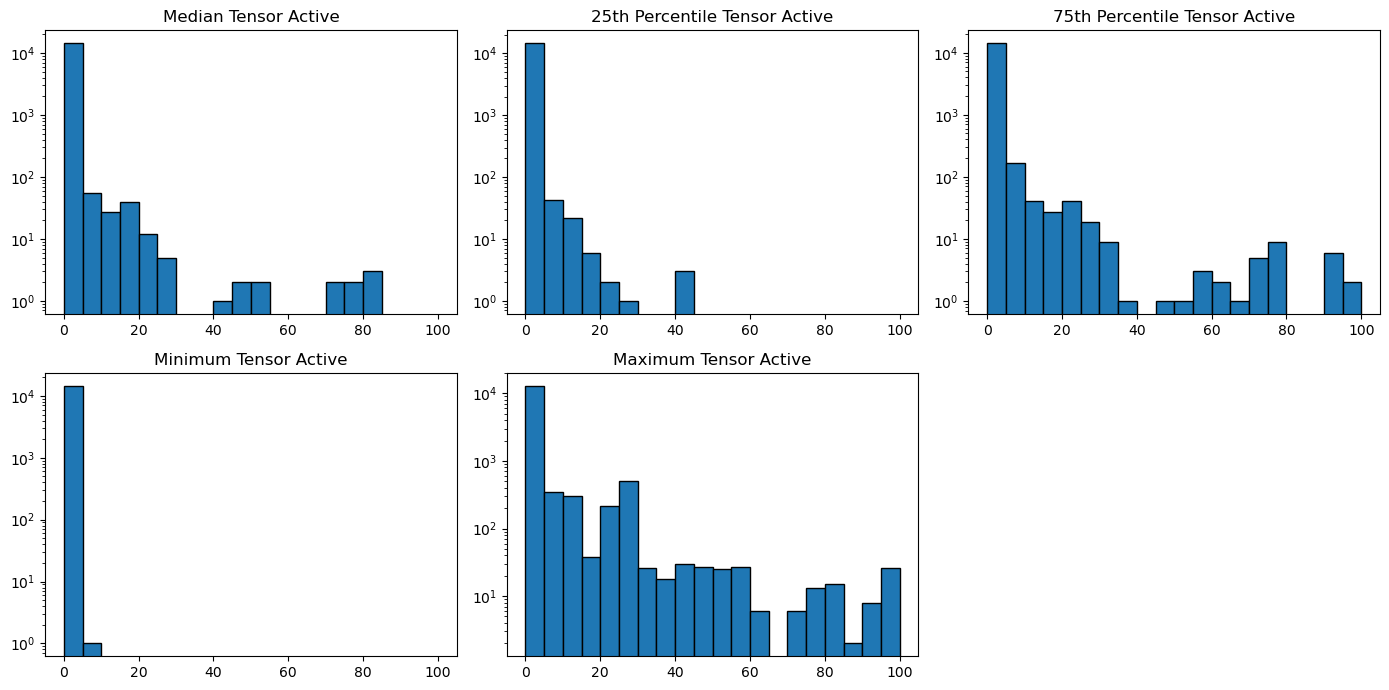

In [13]:
summary_stats = merged_ldms_tensor.groupby('jobid')['tensor_active'].describe(percentiles=[.25, .5, .75]).reset_index()

bins = range(0, 101, 5)  # 0-5, 5-10, ..., 95-100

plt.figure(figsize=(14, 7))

plt.subplot(2, 3, 1)
plt.hist(summary_stats['50%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Median Tensor Active')

plt.subplot(2, 3, 2)
plt.hist(summary_stats['25%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('25th Percentile Tensor Active')

plt.subplot(2, 3, 3)
plt.hist(summary_stats['75%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('75th Percentile Tensor Active')

plt.subplot(2, 3, 4)
plt.hist(summary_stats['min'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Minimum Tensor Active')

plt.subplot(2, 3, 5)
plt.hist(summary_stats['max'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Maximum Tensor Active')

plt.tight_layout()
plt.show()

### How many jobs use each of these metrics?

In [13]:
print(f"Number of jobs that use FP16: {num_fp16_jobs}")

Number of jobs that use FP16: 82


In [14]:
print(f"Number of jobs that use FP32: {num_fp32_jobs}")

Number of jobs that use FP32: 9678


In [14]:
print(f"Number of jobs that use FP64: {num_fp64_jobs}")

Number of jobs that use FP64: 10259


In [13]:
print(f"Number of jobs that use Tensor: {num_tensor_jobs}")

Number of jobs that use Tensor: 10845


### What is the total node hours of jobs that use these metrics?
- How often are double/single/half/tensor floating point operations used?

In [15]:
all_jobs_tensor = merged_ldms_tensor.drop_duplicates(subset='jobid').copy()
all_jobs_tensor['duration_hours'] = all_jobs_tensor['duration'].dt.total_seconds() / 3600.0
all_jobs_tensor['node_hours'] = all_jobs_tensor['nnodes'] * all_jobs_tensor['duration_hours']
total_node_hours = all_jobs_tensor['node_hours'].sum()
print(f"Total node hours: {total_node_hours}")

Total node hours: 62134.41


In [19]:
print(f"Total node hours of jobs that use FP16: {total_node_hours_fp16}")

Total node hours of jobs that use FP16: 280.4605555555555


In [21]:
print(f"Total node hours of jobs that use FP32: {total_node_hours_fp32}")

Total node hours of jobs that use FP32: 38187.98611111111


In [9]:
print(f"Total node hours of jobs that use FP64: {total_node_hours_fp64}")

Total node hours of jobs that use FP64: 38413.056666666664


In [36]:
print(f"Total node hours of jobs that use Tensor: {total_node_hours_tensor}")

Total node hours of jobs that use Tensor: 39736.15611111111
